# Plagiarism Detection, Feature Engineering

In this project, you will be tasked with building a plagiarism detector that examines an answer text file and performs binary classification; labeling that file as either plagiarized or not, depending on how similar that text file is to a provided, source text. 

Your first task will be to create some features that can then be used to train a classification model. This task will be broken down into a few discrete steps:

* Clean and pre-process the data.
* Define features for comparing the similarity of an answer text and a source text, and extract similarity features.
* Select "good" features, by analyzing the correlations between different features.
* Create train/test `.csv` files that hold the relevant features and class labels for train/test data points.

In the _next_ notebook, Notebook 3, you'll use the features and `.csv` files you create in _this_ notebook to train a binary classification model in a SageMaker notebook instance.

You'll be defining a few different similarity features, as outlined in [this paper](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf), which should help you build a robust plagiarism detector!

To complete this notebook, you'll have to complete all given exercises and answer all the questions in this notebook.
> All your tasks will be clearly labeled **EXERCISE** and questions as **QUESTION**.

It will be up to you to decide on the features to include in your final training and test data.

---

## Read in the Data

The cell below will download the necessary, project data and extract the files into the folder `data/`.

This data is a slightly modified version of a dataset created by Paul Clough (Information Studies) and Mark Stevenson (Computer Science), at the University of Sheffield. You can read all about the data collection and corpus, at [their university webpage](https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html). 

> **Citation for data**: Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation: Special Issue on Plagiarism and Authorship Analysis, In Press. [Download]

In [ ]:
# NOTE:
# you only need to run this cell if you have not yet downloaded the data
# otherwise you may skip this cell or comment it out

!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
!unzip data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os

This plagiarism dataset is made of multiple text files; each of these files has characteristics that are is summarized in a `.csv` file named `file_information.csv`, which we can read in using `pandas`.

In [2]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


## Types of Plagiarism

Each text file is associated with one **Task** (task A-E) and one **Category** of plagiarism, which you can see in the above DataFrame.

###  Tasks, A-E

Each text file contains an answer to one short question; these questions are labeled as tasks A-E. For example, Task A asks the question: "What is inheritance in object oriented programming?"

### Categories of plagiarism 

Each text file has an associated plagiarism label/category:

**1. Plagiarized categories: `cut`, `light`, and `heavy`.**
* These categories represent different levels of plagiarized answer texts. `cut` answers copy directly from a source text, `light` answers are based on the source text but include some light rephrasing, and `heavy` answers are based on the source text, but *heavily* rephrased (and will likely be the most challenging kind of plagiarism to detect).
     
**2. Non-plagiarized category: `non`.** 
* `non` indicates that an answer is not plagiarized; the Wikipedia source text is not used to create this answer.
    
**3. Special, source text category: `orig`.**
* This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.

---
## Pre-Process the Data

In the next few cells, you'll be tasked with creating a new DataFrame of desired information about all of the files in the `data/` directory. This will prepare the data for feature extraction and for training a binary, plagiarism classifier.

### EXERCISE: Convert categorical to numerical data

You'll notice that the `Category` column in the data, contains string or categorical values, and to prepare these for feature extraction, we'll want to convert these into numerical values. Additionally, our goal is to create a binary classifier and so we'll need a binary class label that indicates whether an answer text is plagiarized (1) or not (0). Complete the below function `numerical_dataframe` that reads in a `file_information.csv` file by name, and returns a *new* DataFrame with a numerical `Category` column and a new `Class` column that labels each answer as plagiarized or not. 

Your function should return a new DataFrame with the following properties:

* 4 columns: `File`, `Task`, `Category`, `Class`. The `File` and `Task` columns can remain unchanged from the original `.csv` file.
* Convert all `Category` labels to numerical labels according to the following rules (a higher value indicates a higher degree of plagiarism):
    * 0 = `non`
    * 1 = `heavy`
    * 2 = `light`
    * 3 = `cut`
    * -1 = `orig`, this is a special value that indicates an original file.
* For the new `Class` column
    * Any answer text that is not plagiarized (`non`) should have the class label `0`. 
    * Any plagiarized answer texts should have the class label `1`. 
    * And any `orig` texts will have a special label `-1`. 

### Expected output

After running your function, you should get a DataFrame with rows that looks like the following: 
```

        File	     Task  Category  Class
0	g0pA_taska.txt	a	  0   	0
1	g0pA_taskb.txt	b	  3   	1
2	g0pA_taskc.txt	c	  2   	1
3	g0pA_taskd.txt	d	  1   	1
4	g0pA_taske.txt	e	  0	   0
...
...
99   orig_taske.txt    e     -1      -1

```

In [19]:
# Read in a csv file and return a transformed dataframe
def numerical_dataframe(csv_file='data/file_information.csv'):
    '''Reads in a csv file which is assumed to have `File`, `Category` and `Task` columns.
       This function does two things: 
       1) converts `Category` column values to numerical values 
       2) Adds a new, numerical `Class` label column.
       The `Class` column will label plagiarized answers as 1 and non-plagiarized as 0.
       Source texts have a special label, -1.
       :param csv_file: The directory for the file_information.csv file
       :return: A dataframe with numerical categories and a new `Class` label column'''
    
    # your code here
    
    categories = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
    
    dataset = pd.read_csv(csv_file, sep=',')
    dataset['Class'] = dataset['Category'].apply(lambda x: 0 if x == 'non' else -1 if x == 'orig' else 1)
    dataset['Category'] = dataset['Category'].apply(lambda x: categories[x])
    
    return dataset

In [20]:
numerical_dataframe(csv_file ='data/file_information.csv')

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


### Test cells

Below are a couple of test cells. The first is an informal test where you can check that your code is working as expected by calling your function and printing out the returned result.

The **second** cell below is a more rigorous test cell. The goal of a cell like this is to ensure that your code is working as expected, and to form any variables that might be used in _later_ tests/code, in this case, the data frame, `transformed_df`.

> The cells in this notebook should be run in chronological order (the order they appear in the notebook). This is especially important for test cells.

Often, later cells rely on the functions, imports, or variables defined in earlier cells. For example, some tests rely on previous tests to work.

These tests do not test all cases, but they are a great way to check that you are on the right track!

In [21]:
# informal testing, print out the results of a called function
# create new `transformed_df`
transformed_df = numerical_dataframe(csv_file ='data/file_information.csv')

# check work
# check that all categories of plagiarism have a class label = 1
transformed_df.head(10)

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


In [22]:
# test cell that creates `transformed_df`, if tests are passed

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

# importing tests
import problem_unittests as tests

# test numerical_dataframe function
tests.test_numerical_df(numerical_dataframe)

# if above test is passed, create NEW `transformed_df`
transformed_df = numerical_dataframe(csv_file ='data/file_information.csv')

# check work
print('\nExample data: ')
transformed_df.head()

Tests Passed!

Example data: 


,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0


## Text Processing & Splitting Data

Recall that the goal of this project is to build a plagiarism classifier. At it's heart, this task is a comparison text; one that looks at a given answer and a source text, compares them and predicts whether an answer has plagiarized from the source. To effectively do this comparison, and train a classifier we'll need to do a few more things: pre-process all of our text data and prepare the text files (in this case, the 95 answer files and 5 original source files) to be easily compared, and split our data into a `train` and `test` set that can be used to train a classifier and evaluate it, respectively. 

To this end, you've been provided code that adds  additional information to your `transformed_df` from above. The next two cells need not be changed; they add two additional columns to the `transformed_df`:

1. A `Text` column; this holds all the lowercase text for a `File`, with extraneous punctuation removed.
2. A `Datatype` column; this is a string value `train`, `test`, or `orig` that labels a data point as part of our train or test set

The details of how these additional columns are created can be found in the `helpers.py` file in the project directory. You're encouraged to read through that file to see exactly how text is processed and how data is split.

Run the cells below to get a `complete_df` that has all the information you need to proceed with plagiarism detection and feature engineering.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import helpers 

# create a text column 
text_df = helpers.create_text_column(transformed_df)
text_df.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [24]:
# after running the cell above
# check out the processed text for a single file, by row index
row_idx = 0 # feel free to change this index

sample_text = text_df.iloc[0]['Text']

print('Sample processed text:\n\n', sample_text)

Sample processed text:

 inheritance is a basic concept of object oriented programming where the basic idea is to create new classes that add extra detail to existing classes this is done by allowing the new classes to reuse the methods and variables of the existing classes and new methods and classes are added to specialise the new class inheritance models the is kind of relationship between entities or objects  for example postgraduates and undergraduates are both kinds of student this kind of relationship can be visualised as a tree structure where student would be the more general root node and both postgraduate and undergraduate would be more specialised extensions of the student node or the child nodes  in this relationship student would be known as the superclass or parent class whereas  postgraduate would be known as the subclass or child class because the postgraduate class extends the student class  inheritance can occur on several layers where if visualised would display a l

## Split data into training and test sets

The next cell will add a `Datatype` column to a given DataFrame to indicate if the record is: 
* `train` - Training data, for model training.
* `test` - Testing data, for model evaluation.
* `orig` - The task's original answer from wikipedia.

### Stratified sampling

The given code uses a helper function which you can view in the `helpers.py` file in the main project directory. This implements [stratified random sampling](https://en.wikipedia.org/wiki/Stratified_sampling) to randomly split data by task & plagiarism amount. Stratified sampling ensures that we get training and test data that is fairly evenly distributed across task & plagiarism combinations. Approximately 26% of the data is held out for testing and 74% of the data is used for training.

The function **train_test_dataframe** takes in a DataFrame that it assumes has `Task` and `Category` columns, and, returns a modified frame that indicates which `Datatype` (train, test, or orig) a file falls into. This sampling will change slightly based on a passed in *random_seed*. Due to a small sample size, this stratified random sampling will provide more stable results for a binary plagiarism classifier. Stability here is smaller *variance* in the accuracy of classifier, given a random seed.

In [25]:
random_seed = 1 # can change; set for reproducibility

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import helpers

# create new df with Datatype (train, test, orig) column
# pass in `text_df` from above to create a complete dataframe, with all the information you need
complete_df = helpers.train_test_dataframe(text_df, random_seed=random_seed)

# check results
complete_df.head(10)

,File,Task,Category,Class,Text,Datatype
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,train
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train
5,g0pB_taska.txt,a,0,0,inheritance is a basic concept in object orien...,train
6,g0pB_taskb.txt,b,0,0,pagerank pr refers to both the concept and the...,train
7,g0pB_taskc.txt,c,3,1,vector space model is an algebraic model for r...,test
8,g0pB_taskd.txt,d,2,1,bayes theorem relates the conditional and marg...,train
9,g0pB_taske.txt,e,1,1,dynamic programming is a method for solving ma...,test


# Determining Plagiarism

Now that you've prepared this data and created a `complete_df` of information, including the text and class associated with each file, you can move on to the task of extracting similarity features that will be useful for plagiarism classification. 

> Note: The following code exercises, assume that the `complete_df` as it exists now, will **not** have its existing columns modified. 

The `complete_df` should always include the columns: `['File', 'Task', 'Category', 'Class', 'Text', 'Datatype']`. You can add additional columns, and you can create any new DataFrames you need by copying the parts of the `complete_df` as long as you do not modify the existing values, directly.

---


# Similarity Features 

One of the ways we might go about detecting plagiarism, is by computing **similarity features** that measure how similar a given answer text is as compared to the original wikipedia source text (for a specific task, a-e). The similarity features you will use are informed by [this paper on plagiarism detection](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf). 
> In this paper, researchers created features called **containment** and **longest common subsequence**. 

Using these features as input, you will train a model to distinguish between plagiarized and not-plagiarized text files.

## Feature Engineering

Let's talk a bit more about the features we want to include in a plagiarism detection model and how to calculate such features. In the following explanations, I'll refer to a submitted text file as a **Student Answer Text (A)** and the original, wikipedia source file (that we want to compare that answer to) as the **Wikipedia Source Text (S)**.

### Containment

Your first task will be to create **containment features**. To understand containment, let's first revisit a definition of [n-grams](https://en.wikipedia.org/wiki/N-gram). An *n-gram* is a sequential word grouping. For example, in a line like "bayes rule gives us a way to combine prior knowledge with new information," a 1-gram is just one word, like "bayes." A 2-gram might be "bayes rule" and a 3-gram might be "combine prior knowledge."

> Containment is defined as the **intersection** of the n-gram word count of the Wikipedia Source Text (S) with the n-gram word count of the Student  Answer Text (S) *divided* by the n-gram word count of the Student Answer Text.

$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$

If the two texts have no n-grams in common, the containment will be 0, but if _all_ their n-grams intersect then the containment will be 1. Intuitively, you can see how having longer n-gram's in common, might be an indication of cut-and-paste plagiarism. In this project, it will be up to you to decide on the appropriate `n` or several `n`'s to use in your final model.

### EXERCISE: Create containment features

Given the `complete_df` that you've created, you should have all the information you need to compare any Student  Answer Text (A) with its appropriate Wikipedia Source Text (S). An answer for task A should be compared to the source text for task A, just as answers to tasks B, C, D, and E should be compared to the corresponding original source text.

In this exercise, you'll complete the function, `calculate_containment` which calculates containment based upon the following parameters:
* A given DataFrame, `df` (which is assumed to be the `complete_df` from above)
* An `answer_filename`, such as 'g0pB_taskd.txt' 
* An n-gram length, `n`

### Containment calculation

The general steps to complete this function are as follows:
1. From *all* of the text files in a given `df`, create an array of n-gram counts; it is suggested that you use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for this purpose.
2. Get the processed answer and source texts for the given `answer_filename`.
3. Calculate the containment between an answer and source text according to the following equation.

    >$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$
    
4. Return that containment value.

You are encouraged to write any helper functions that you need to complete the function below.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [57]:
complete_df

,File,Task,Category,Class,Text,Datatype
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,test
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,train
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train
5,g0pB_taska.txt,a,0,0,inheritance is a basic concept in object orien...,train
6,g0pB_taskb.txt,b,0,0,pagerank pr refers to both the concept and the...,train
7,g0pB_taskc.txt,c,3,1,vector space model is an algebraic model for r...,test
8,g0pB_taskd.txt,d,2,1,bayes theorem relates the conditional and marg...,train
9,g0pB_taske.txt,e,1,1,dynamic programming is a method for solving ma...,test


In [150]:
# Calculate the ngram containment for one answer file/source file pair in a df
def calculate_containment(df, n, answer_filename):
    '''Calculates the containment between a given answer text and its associated source text.
       This function creates a count of ngrams (of a size, n) for each text file in our data.
       Then calculates the containment by finding the ngram count for a given answer text, 
       and its associated source text, and calculating the normalized intersection of those counts.
       :param df: A dataframe with columns,
           'File', 'Task', 'Category', 'Class', 'Text', and 'Datatype'
       :param n: An integer that defines the ngram size
       :param answer_filename: A filename for an answer text in the df, ex. 'g0pB_taskd.txt'
       :return: A single containment value that represents the similarity
           between an answer text and its source text.
    '''
    
    # your code here
    filter_answer_df = df[df['File'] == answer_filename]  # getting row which contains answer_filename
    task = filter_answer_df['Task'].item()  # which task the answer belongs
    answer_text = filter_answer_df['Text'].item()  # submited text answer
    
    filter_wiki_df = df[(df['Task'] == task) & (df['Class'] == -1)]  # getting which contains orignal text  
    wiki_text = filter_wiki_df['Text'].item()  # original text from Wiki based on task
    
    bow = CountVectorizer(analyzer='word', ngram_range=(n, n))  # bag of words 
    ngrams = bow.fit_transform([answer_text, wiki_text])  # getting ngrams
    ngrams = ngrams.toarray()  # sparse to numpy array
    
    # containment
    count_ngram_a = ngrams[0].sum()  # number of words in answer ngram array
    count_ngram_intercetion = np.minimum(*ngrams).sum()  # intersection count
        
    return count_ngram_intercetion / count_ngram_a

### Test cells

After you've implemented the containment function, you can test out its behavior. 

The cell below iterates through the first few files, and calculates the original category _and_ containment values for a specified n and file.

>If you've implemented this correctly, you should see that the non-plagiarized have low or close to 0 containment values and that plagiarized examples have higher containment values, closer to 1.

Note what happens when you change the value of n. I recommend applying your code to multiple files and comparing the resultant containment values. You should see that the highest containment values correspond to files with the highest category (`cut`) of plagiarism level.

In [151]:
# select a value for n
n = 3

# indices for first few files
test_indices = range(5)

# iterate through files and calculate containment
category_vals = []
containment_vals = []
for i in test_indices:
    # get level of plagiarism for a given file index
    category_vals.append(complete_df.loc[i, 'Category'])
    # calculate containment for given file and n
    filename = complete_df.loc[i, 'File']
    c = calculate_containment(complete_df, n, filename)
    containment_vals.append(c)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print(str(n)+'-gram containment values: \n', containment_vals)

Original category values: 
 [0, 3, 2, 1, 0]

3-gram containment values: 
 [0.009345794392523364, 0.9641025641025641, 0.6136363636363636, 0.15675675675675677, 0.031746031746031744]


In [152]:
# run this test cell
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# test containment calculation
# params: complete_df from before, and containment function
tests.test_containment(complete_df, calculate_containment)

Tests Passed!


### QUESTION 1: Why can we calculate containment features across *all* data (training & test), prior to splitting the DataFrame for modeling? That is, what about the containment calculation means that the test and training data do not influence each other?

**Answer:** We can calculate containment features across all database because of 2 reasons: we have to calculate the containment to use as our model input and each containment are independent from the others (it's not being influenced) considering we only need the answer text and the original text to calculate, without using others answers.

---
## Longest Common Subsequence

Containment a good way to find overlap in word usage between two documents; it may help identify cases of cut-and-paste as well as paraphrased levels of plagiarism. Since plagiarism is a fairly complex task with varying levels, it's often useful to include other measures of similarity. The paper also discusses a feature called **longest common subsequence**.

> The longest common subsequence is the longest string of words (or letters) that are *the same* between the Wikipedia Source Text (S) and the Student Answer Text (A). This value is also normalized by dividing by the total number of words (or letters) in the  Student Answer Text. 

In this exercise, we'll ask you to calculate the longest common subsequence of words between two texts.

### EXERCISE: Calculate the longest common subsequence

Complete the function `lcs_norm_word`; this should calculate the *longest common subsequence* of words between a Student Answer Text and corresponding Wikipedia Source Text. 

It may be helpful to think of this in a concrete example. A Longest Common Subsequence (LCS) problem may look as follows:
* Given two texts: text A (answer text) of length n, and string S (original source text) of length m. Our goal is to produce their longest common subsequence of words: the longest sequence of words that appear left-to-right in both texts (though the words don't have to be in continuous order).
* Consider:
    * A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
    * S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

* In this case, we can see that the start of each sentence of fairly similar, having overlap in the sequence of words, "pagerank is a link analysis algorithm used by" before diverging slightly. Then we **continue moving left -to-right along both texts** until we see the next common sequence; in this case it is only one word, "google". Next we find "that" and "a" and finally the same ending "to each element of a hyperlinked set of documents".
* Below, is a clear visual of how these sequences were found, sequentially, in each text.

<img src='notebook_ims/common_subseq_words.png' width=40% />

* Now, those words appear in left-to-right order in each document, sequentially, and even though there are some words in between, we count this as the longest common subsequence between the two texts. 
* If I count up each word that I found in common I get the value 20. **So, LCS has length 20**. 
* Next, to normalize this value, divide by the total length of the student answer; in this example that length is only 27. **So, the function `lcs_norm_word` should return the value `20/27` or about `0.7408`.**

In this way, LCS is a great indicator of cut-and-paste plagiarism or if someone has referenced the same source text multiple times in an answer.

### LCS, dynamic programming

If you read through the scenario above, you can see that this algorithm depends on looking at two texts and comparing them word by word. You can solve this problem in multiple ways. First, it may be useful to `.split()` each text into lists of comma separated words to compare. Then, you can iterate through each word in the texts and compare them, adding to your value for LCS as you go. 

The method I recommend for implementing an efficient LCS algorithm is: using a matrix and dynamic programming. **Dynamic programming** is all about breaking a larger problem into a smaller set of subproblems, and building up a complete result without having to repeat any subproblems. 

This approach assumes that you can split up a large LCS task into a combination of smaller LCS tasks. Let's look at a simple example that compares letters:

* A = "ABCD"
* S = "BD"

We can see right away that the longest subsequence of _letters_ here is 2 (B and D are in sequence in both strings). And we can calculate this by looking at relationships between each letter in the two strings, A and S.

Here, I have a matrix with the letters of A on top and the letters of S on the left side:

<img src='notebook_ims/matrix_1.png' width=40% />

This starts out as a matrix that has as many columns and rows as letters in the strings S and O **+1** additional row and column, filled with zeros on the top and left sides. So, in this case, instead of a 2x4 matrix it is a 3x5.

Now, we can fill this matrix up by breaking it into smaller LCS problems. For example, let's first look at the shortest substrings: the starting letter of A and S. We'll first ask, what is the Longest Common Subsequence between these two letters "A" and "B"? 

**Here, the answer is zero and we fill in the corresponding grid cell with that value.**

<img src='notebook_ims/matrix_2.png' width=30% />

Then, we ask the next question, what is the LCS between "AB" and "B"?

**Here, we have a match, and can fill in the appropriate value 1**.

<img src='notebook_ims/matrix_3_match.png' width=25% />

If we continue, we get to a final matrix that looks as follows, with a **2** in the bottom right corner.

<img src='notebook_ims/matrix_6_complete.png' width=25% />

The final LCS will be that value **2** *normalized* by the number of n-grams in A. So, our normalized value is 2/4 = **0.5**.

### The matrix rules

One thing to notice here is that, you can efficiently fill up this matrix one cell at a time. Each grid cell only depends on the values in the grid cells that are directly on top and to the left of it, or on the diagonal/top-left. The rules are as follows:
* Start with a matrix that has one extra row and column of zeros.
* As you traverse your string:
    * If there is a match, fill that grid cell with the value to the top-left of that cell *plus* one. So, in our case, when we found a matching B-B, we added +1 to the value in the top-left of the matching cell, 0.
    * If there is not a match, take the *maximum* value from either directly to the left or the top cell, and carry that value over to the non-match cell.

<img src='notebook_ims/matrix_rules.png' width=50% />

After completely filling the matrix, **the bottom-right cell will hold the non-normalized LCS value**.

This matrix treatment can be applied to a set of words instead of letters. Your function should apply this to the words in two texts and return the normalized LCS value.

In [186]:
# Compute the normalized LCS given an answer text and a source text
def lcs_norm_word(answer_text, source_text):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
    # your code here
    
    answer_text = answer_text.split()  # array of words
    answer_text_length = len(answer_text)
    
    source_text = source_text.split()  # array of words
    source_text_length = len(source_text)
    
    lcs_matrix = np.zeros((source_text_length + 1, answer_text_length + 1), dtype=int)  # lcs matrix with padding
    
    for i in range(source_text_length):  # for each word in source text
        for j in range(answer_text_length):  # for each word in answer text
            if source_text[i] == answer_text[j]:
                lcs_matrix[i+1,j+1] = lcs_matrix[i,j] + 1  # match: diagonal addition
            else:
                lcs_matrix[i+1,j+1] = max(lcs_matrix[i+1,j], lcs_matrix[i,j+1])  # no match: max of top/left values
    
    # non-normalized LCS value / answer_text_length == normalized LCS value
    lcs_value = lcs_matrix[-1,-1] / answer_text_length  #
    
    return lcs_value

In [163]:
A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"
lcs_norm_word(A, S)

0.7407407407407407

In [173]:
np.ones((20, 20))[10, 10]

1.0

### Test cells

Let's start by testing out your code on the example given in the initial description.

In the below cell, we have specified strings A (answer text) and S (original source text). We know that these texts have 20 words in common and the submitted answer is 27 words long, so the normalized, longest common subsequence should be 20/27.


In [187]:
# Run the test scenario from above
# does your function return the expected value?

A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"

# calculate LCS
lcs = lcs_norm_word(A, S)
print('LCS = ', lcs)


# expected value test
assert lcs==20/27., "Incorrect LCS value, expected about 0.7408, got "+str(lcs)

print('Test passed!')

LCS =  0.7407407407407407
Test passed!


This next cell runs a more rigorous test.

In [188]:
# run test cell
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# test lcs implementation
# params: complete_df from before, and lcs_norm_word function
tests.test_lcs(complete_df, lcs_norm_word)

Tests Passed!


Finally, take a look at a few resultant values for `lcs_norm_word`. Just like before, you should see that higher values correspond to higher levels of plagiarism.

In [189]:
# test on your own
test_indices = range(5) # look at first few files

category_vals = []
lcs_norm_vals = []
# iterate through first few docs and calculate LCS
for i in test_indices:
    category_vals.append(complete_df.loc[i, 'Category'])
    # get texts to compare
    answer_text = complete_df.loc[i, 'Text'] 
    task = complete_df.loc[i, 'Task']
    # we know that source texts have Class = -1
    orig_rows = complete_df[(complete_df['Class'] == -1)]
    orig_row = orig_rows[(orig_rows['Task'] == task)]
    source_text = orig_row['Text'].values[0]
    
    # calculate lcs
    lcs_val = lcs_norm_word(answer_text, source_text)
    lcs_norm_vals.append(lcs_val)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print('Normalized LCS values: \n', lcs_norm_vals)

Original category values: 
 [0, 3, 2, 1, 0]

Normalized LCS values: 
 [0.1917808219178082, 0.8207547169811321, 0.8464912280701754, 0.3160621761658031, 0.24257425742574257]


---
# Create All Features

Now that you've completed the feature calculation functions, it's time to actually create multiple features and decide on which ones to use in your final model! In the below cells, you're provided two helper functions to help you create multiple features and store those in a DataFrame, `features_df`.

### Creating multiple containment features

Your completed `calculate_containment` function will be called in the next cell, which defines the helper function `create_containment_features`. 

> This function returns a list of containment features, calculated for a given `n` and for *all* files in a df (assumed to the the `complete_df`).

For our original files, the containment value is set to a special value, -1.

This function gives you the ability to easily create several containment features, of different n-gram lengths, for each of our text files.

In [190]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Function returns a list of containment features, calculated for a given n 
# Should return a list of length 100 for all files in a complete_df
def create_containment_features(df, n, column_name=None):
    
    containment_values = []
    
    if(column_name==None):
        column_name = 'c_'+str(n) # c_1, c_2, .. c_n
    
    # iterates through dataframe rows
    for i in df.index:
        file = df.loc[i, 'File']
        # Computes features using calculate_containment function
        if df.loc[i,'Category'] > -1:
            c = calculate_containment(df, n, file)
            containment_values.append(c)
        # Sets value to -1 for original tasks 
        else:
            containment_values.append(-1)
    
    print(str(n)+'-gram containment features created!')
    return containment_values


### Creating LCS features

Below, your complete `lcs_norm_word` function is used to create a list of LCS features for all the answer files in a given DataFrame (again, this assumes you are passing in the `complete_df`. It assigns a special value for our original, source files, -1.


In [191]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Function creates lcs feature and add it to the dataframe
def create_lcs_features(df, column_name='lcs_word'):
    
    lcs_values = []
    
    # iterate through files in dataframe
    for i in df.index:
        # Computes LCS_norm words feature using function above for answer tasks
        if df.loc[i,'Category'] > -1:
            # get texts to compare
            answer_text = df.loc[i, 'Text'] 
            task = df.loc[i, 'Task']
            # we know that source texts have Class = -1
            orig_rows = df[(df['Class'] == -1)]
            orig_row = orig_rows[(orig_rows['Task'] == task)]
            source_text = orig_row['Text'].values[0]

            # calculate lcs
            lcs = lcs_norm_word(answer_text, source_text)
            lcs_values.append(lcs)
        # Sets to -1 for original tasks 
        else:
            lcs_values.append(-1)

    print('LCS features created!')
    return lcs_values
    

## EXERCISE: Create a features DataFrame by selecting an `ngram_range`

The paper suggests calculating the following features: containment *1-gram to 5-gram* and *longest common subsequence*. 
> In this exercise, you can choose to create even more features, for example from *1-gram to 7-gram* containment features and *longest common subsequence*. 

You'll want to create at least 6 features to choose from as you think about which to give to your final, classification model. Defining and comparing at least 6 different features allows you to discard any features that seem redundant, and choose to use the best features for your final model!

In the below cell **define an n-gram range**; these will be the n's you use to create n-gram containment features. The rest of the feature creation code is provided.

In [211]:
# Define an ngram range
ngram_range = range(1,11)


# The following code may take a minute to run, depending on your ngram_range
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
features_list = []

# Create features in a features_df
all_features = np.zeros((len(ngram_range)+1, len(complete_df)))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(complete_df, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(complete_df))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

1-gram containment features created!
2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
7-gram containment features created!
8-gram containment features created!
9-gram containment features created!
10-gram containment features created!
LCS features created!

Features:  ['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'lcs_word']



In [212]:
# print some results 
features_df.head(10)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,lcs_word
0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.191781
1,1.000000,0.984694,0.964103,0.943299,0.922280,0.901042,0.879581,0.857895,0.835979,0.813830,0.820755
2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.319444,0.265116,0.219626,0.197183,0.846491
3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.044199,0.027778,0.011173,0.000000,0.316062
4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242574
5,0.329502,0.053846,0.007722,0.003876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161172
6,0.590308,0.150442,0.035556,0.004464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301653
7,0.765306,0.709898,0.664384,0.625430,0.589655,0.553633,0.520833,0.487805,0.454545,0.424561,0.621711
8,0.759777,0.505618,0.395480,0.306818,0.245714,0.195402,0.150289,0.110465,0.070175,0.035294,0.484305
9,0.884444,0.526786,0.340807,0.247748,0.180995,0.150000,0.118721,0.091743,0.064516,0.041667,0.597458


## Correlated Features

You should use feature correlation across the *entire* dataset to determine which features are ***too*** **highly-correlated** with each other to include both features in a single model. For this analysis, you can use the *entire* dataset due to the small sample size we have. 

All of our features try to measure the similarity between two texts. Since our features are designed to measure similarity, it is expected that these features will be highly-correlated. Many classification models, for example a Naive Bayes classifier, rely on the assumption that features are *not* highly correlated; highly-correlated features may over-inflate the importance of a single feature. 

So, you'll want to choose your features based on which pairings have the lowest correlation. These correlation values range between 0 and 1; from low to high correlation, and are displayed in a [correlation matrix](https://www.displayr.com/what-is-a-correlation-matrix/), below.

In [213]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Create correlation matrix for just Features to determine different models to test
corr_matrix = features_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,lcs_word
c_1,1.00,0.94,0.90,0.89,0.88,0.87,0.87,0.87,0.86,0.86,0.97
c_2,0.94,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.94,0.93,0.98
c_3,0.90,0.99,1.00,1.00,0.99,0.98,0.98,0.97,0.96,0.95,0.97
c_4,0.89,0.98,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.97,0.95
c_5,0.88,0.97,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.98,0.95
c_6,0.87,0.96,0.98,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.94
c_7,0.87,0.95,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,0.93
c_8,0.87,0.94,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,0.92
c_9,0.86,0.94,0.96,0.98,0.99,0.99,1.00,1.00,1.00,1.00,0.91
c_10,0.86,0.93,0.95,0.97,0.98,0.99,1.00,1.00,1.00,1.00,0.91


In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

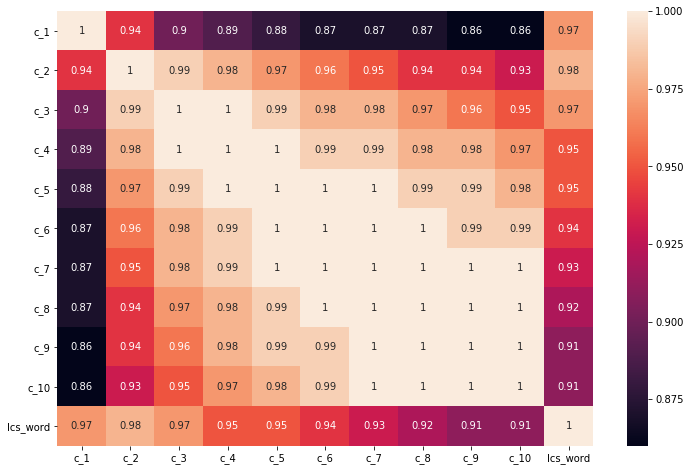

In [221]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)

In [ ]:
## pairings that have the lowest correlation <= 0.9
# c_1 (c_3, c_4, c_5, c_6)
# c_2 (X)
# c_3 (c_1)
# c_4 (c_1)
# c_5 (c_1)
# c_6 (c_1)
# lcs (X)

## EXERCISE: Create selected train/test data

Complete the `train_test_data` function below. This function should take in the following parameters:
* `complete_df`: A DataFrame that contains all of our processed text data, file info, datatypes, and class labels
* `features_df`: A DataFrame of all calculated features, such as containment for ngrams, n= 1-5, and lcs values for each text file listed in the `complete_df` (this was created in the above cells)
* `selected_features`: A list of feature column names,  ex. `['c_1', 'lcs_word']`, which will be used to select the final features in creating train/test sets of data.

It should return two tuples:
* `(train_x, train_y)`, selected training features and their corresponding class labels (0/1)
* `(test_x, test_y)`, selected training features and their corresponding class labels (0/1)

** Note: x and y should be arrays of feature values and numerical class labels, respectively; not DataFrames.**

Looking at the above correlation matrix, you should decide on a **cutoff** correlation value, less than 1.0, to determine which sets of features are *too* highly-correlated to be included in the final training and test data. If you cannot find features that are less correlated than some cutoff value, it is suggested that you increase the number of features (longer n-grams) to choose from or use *only one or two* features in your final model to avoid introducing highly-correlated features.

Recall that the `complete_df` has a `Datatype` column that indicates whether data should be `train` or `test` data; this should help you split the data appropriately.

In [222]:
# Takes in dataframes and a list of selected features (column names) 
# and returns (train_x, train_y), (test_x, test_y)
def train_test_data(complete_df, features_df, selected_features):
    '''Gets selected training and test features from given dataframes, and 
       returns tuples for training and test features and their corresponding class labels.
       :param complete_df: A dataframe with all of our processed text data, datatypes, and labels
       :param features_df: A dataframe of all computed, similarity features
       :param selected_features: An array of selected features that correspond to certain columns in `features_df`
       :return: training and test features and labels: (train_x, train_y), (test_x, test_y)'''
    
    concat_df = pd.concat([complete_df, features_df], axis=1)
    train_df = concat_df[concat_df['Datatype'] == 'train']
    test_df = concat_df[concat_df['Datatype'] == 'test']
    
    # get the training features
    train_x = train_df[selected_features].values
    # And training class labels (0 or 1)
    train_y = train_df['Class'].values
    
    # get the test features and labels
    test_x = test_df[selected_features].values
    test_y = test_df['Class'].values
    
    return (train_x, train_y), (test_x, test_y)
    

### Test cells

Below, test out your implementation and create the final train/test data.

In [223]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_selection = list(features_df)[:2] # first couple columns as a test
# test that the correct train/test data is created
(train_x, train_y), (test_x, test_y) = train_test_data(complete_df, features_df, test_selection)

# params: generated train/test data
tests.test_data_split(train_x, train_y, test_x, test_y)

Tests Passed!


## EXERCISE: Select "good" features

If you passed the test above, you can create your own train/test data, below. 

Define a list of features you'd like to include in your final mode, `selected_features`; this is a list of the features names you want to include.

In [226]:
# Select your list of features, this should be column names from features_df
# ex. ['c_1', 'lcs_word']
selected_features = ['c_1', 'c_2', 'c_4', 'c_6', 'lcs_word']


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

(train_x, train_y), (test_x, test_y) = train_test_data(complete_df, features_df, selected_features)

# check that division of samples seems correct
# these should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', train_x[:10])

Training size:  70
Test size:  25

Training df sample: 
 [[0.39814815 0.07906977 0.         0.         0.19178082]
 [0.86936937 0.71945701 0.51598174 0.38248848 0.84649123]
 [0.59358289 0.2688172  0.10869565 0.06043956 0.31606218]
 [0.54450262 0.11578947 0.00531915 0.         0.24257426]
 [0.32950192 0.05384615 0.00387597 0.         0.16117216]
 [0.59030837 0.15044248 0.00446429 0.         0.30165289]
 [0.75977654 0.50561798 0.30681818 0.1954023  0.48430493]
 [0.51612903 0.07027027 0.         0.         0.27083333]
 [0.44086022 0.11891892 0.00546448 0.         0.22395833]
 [0.97945205 0.91724138 0.83216783 0.74468085 0.9       ]]


### Question 2: How did you decide on which features to include in your final model? 

**Answer:** Based on the text above ("choose features on which pairings have the lowest correlation"), I noticed that from feature c_6 to feature c_10 they are highly correlated, so I decided to cut them off and keep only one (c_6). Also, the features c_3 and c_4, and c_4 and c_5 have correlation equal 1, so only one of theses features is suficient to take to the model (c_4).


---
## Creating Final Data Files

Now, you are almost ready to move on to training a model in SageMaker!

You'll want to access your train and test data in SageMaker and upload it to S3. In this project, SageMaker will expect the following format for your train/test data:
* Training and test data should be saved in one `.csv` file each, ex `train.csv` and `test.csv`
* These files should have class  labels in the first column and features in the rest of the columns

This format follows the practice, outlined in the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html), which reads: "Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable [class label] is in the first column."

## EXERCISE: Create csv files

Define a function that takes in x (features) and y (labels) and saves them to one `.csv` file at the path `data_dir/filename`.

It may be useful to use pandas to merge your features and labels into one DataFrame and then convert that into a csv file. You can make sure to get rid of any incomplete rows, in a DataFrame, by using `dropna`.

In [229]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    # your code here
    dataset = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    dataset.to_csv(os.path.join(data_dir, filename), index=False, header=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

### Test cells

Test that your code produces the correct format for a `.csv` file, given some text features and labels.

In [230]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
fake_x = [ [0.39814815, 0.0001, 0.19178082], 
           [0.86936937, 0.44954128, 0.84649123], 
           [0.44086022, 0., 0.22395833] ]

fake_y = [0, 1, 1]

make_csv(fake_x, fake_y, filename='to_delete.csv', data_dir='test_csv')

# read in and test dimensions
fake_df = pd.read_csv('test_csv/to_delete.csv', header=None)

# check shape
assert fake_df.shape==(3, 4), \
      'The file should have as many rows as data_points and as many columns as features+1 (for indices).'
# check that first column = labels
assert np.all(fake_df.iloc[:,0].values==fake_y), 'First column is not equal to the labels, fake_y.'
print('Tests passed!')

Path created: test_csv/to_delete.csv
Tests passed!


In [231]:
# delete the test csv file, generated above
! rm -rf test_csv

If you've passed the tests above, run the following cell to create `train.csv` and `test.csv` files in a directory that you specify! This will save the data in a local directory. Remember the name of this directory because you will reference it again when uploading this data to S3.

In [232]:
# can change directory, if you want
data_dir = 'plagiarism_data'

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

make_csv(train_x, train_y, filename='train.csv', data_dir=data_dir)
make_csv(test_x, test_y, filename='test.csv', data_dir=data_dir)

Path created: plagiarism_data/train.csv
Path created: plagiarism_data/test.csv


## Up Next

Now that you've done some feature engineering and created some training and test data, you are ready to train and deploy a plagiarism classification model. The next notebook will utilize SageMaker resources to train and test a model that you design.